In [1]:
import pandas as pd
import numpy as np

# Load data
loans = pd.read_csv('loans_full_schema.csv')

In [ ]:
R_MAX = 0.3589          # Maximum APR
MONTHLY_DEFAULT_PROB = 1 - (1 - 0.06) ** (1 / 12)  # Approx. 0.005
MONTHLY_SURVIVAL = 1 - MONTHLY_DEFAULT_PROB     # ≈ 0.9958

def calculate_present_value(row):
    """Calculate the default-adjusted present value of monthly payments."""
    term = int(row['term'])  # Loan term in months (36 or 60)
    installment = row['installment']
    monthly_discount = 1 + R_MAX / 12
    
    total_pv = 0.0
    for t in range(1, term + 1):
        survival_prob = MONTHLY_SURVIVAL ** t
        discounted_payment = installment * survival_prob / (monthly_discount ** t)
        total_pv += discounted_payment
    return total_pv

# Calculate present value for each loan
loans['present_value'] = loans.apply(calculate_present_value, axis=1)

In [3]:
FEE_MIN = 0.03        # Minimum origination fee rate
FEE_MAX = 0.08        # Maximum origination fee rate

loans["min_required_pv"] = loans["loan_amount"] * (1 - FEE_MAX)
infeasible_mask = loans["present_value"] < loans["min_required_pv"]
infeasible_loans = loans[infeasible_mask]
feasible_loans = loans[~infeasible_mask].copy()

print(f"Excluded {len(infeasible_loans)} loans violating minimum PV requirement:")
if len(infeasible_loans) > 0:
    print(infeasible_loans[["loan_amount", "term", "installment", "present_value", "min_required_pv"]])
else:
    print("(None)")

Excluded 6169 loans violating minimum PV requirement:
      loan_amount  term  installment  present_value  min_required_pv
0           28000    60       652.53   25696.806856          25760.0
3           21600    36       664.19   18371.949912          19872.0
5            5000    36       153.75    4252.830213           4600.0
6           24000    60       553.35   21791.071788          22080.0
7           20000    60       444.79   17515.949798          18400.0
...           ...   ...          ...            ...              ...
9993         5000    36       156.62    4332.216377           4600.0
9994         4800    36       155.81    4309.811222           4416.0
9995        24000    36       744.90   20604.443743          22080.0
9998        24000    36       722.76   19992.036193          22080.0
9999        12800    36       418.52   11576.549598          11776.0

[6169 rows x 5 columns]


In [4]:
import pulp
N = len(feasible_loans)

# New risk score created for each loan
feasible_loans['risk_score'] = (
    0.6 * loans['grade'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}) +  # Grade weight
    0.4 * loans['interest_rate'] / 0.18                        # Interest rate weight
)

# --- 3. Define PuLP Problem ---
prob = pulp.LpProblem("Origination_Fee_Optimization", pulp.LpMaximize)

# Decision variables: origination fees (0.03 <= f_i <= 0.08)
f = pulp.LpVariable.dicts("fee", range(N), lowBound= FEE_MIN, upBound=FEE_MAX)
L = feasible_loans['loan_amount'].values

# Objective: Maximize sum(f_i * L_i)
#prob += pulp.lpSum([f[i] * feasible_loans['loan_amount'].iloc[i] for i in range(N)])

# Objective: Maximize sum(f_i * L_i) - 0.1 * risk score
prob += pulp.lpSum([f[i] * L[i] for i in range(N)]) - 0.1 * pulp.lpSum([f[i] * L[i] * feasible_loans['risk_score'].iloc[i] for i in range(N)])

# Constraints
for i in range(N):
    # PV_i >= L_i * (1 - f_i)
    prob += feasible_loans['loan_amount'].iloc[i] * (1 - f[i]) <= feasible_loans['present_value'].iloc[i], f"PV_constraint_{i}"

    # Grade-based minimum fee (A: 3%, B: 4%, etc.)
    grade_min_fee = {
        'A': 0.03, 'B': 0.04, 'C': 0.05, 'D': 0.06, 'E': 0.07, 'F': 0.08, 'G': 0.08
    }.get(feasible_loans['grade'].iloc[i], 0.03)
    prob += f[i] >= grade_min_fee, f"Grade_constraint_{i}"

    # Fee linked to interest rate: f_i >= 0.2 * r_i
    prob += f[i] >= 0.2 * (feasible_loans['interest_rate'].iloc[i] / 100), f"Interest_rate_constraint_{i}"

# --- 4. Solve ---
prob.solve()

# --- 5. Results ---
if pulp.LpStatus[prob.status] == 'Optimal':
    optimal_fees = [f[i].varValue for i in range(N)]
    total_revenue = sum(optimal_fees[i] * feasible_loans['loan_amount'].iloc[i] for i in range(N))
    print("Optimal origination fees:", optimal_fees)
    print("Total revenue:", total_revenue)
else:
    print("Optimization failed. Status:", pulp.LpStatus[prob.status])

feasible_loans['optimal_fee'] = optimal_fees

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/alanwang/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/c61d75e5a14347e7bef2129202102356-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/c61d75e5a14347e7bef2129202102356-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11498 COLUMNS
At line 26823 RHS
At line 38317 BOUNDS
At line 45980 ENDATA
Problem MODEL has 11493 rows, 3831 columns and 11493 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-11493) rows, 0 (-3831) columns and 0 (-11493) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value -11991492
After Postsolve, objective -11991492, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -11991492.01 - 0 iterations time 

In [11]:
# Categorize loans into amount tiers
bins = [1000, 6000, 12000, 18000, 25000, 32000, 40000]
labels = ['1K-5K', '6K-11K', '12K-17K', '18K-24K', '25K-31K', '32K-40K']
feasible_loans['loan_amount_tier'] = pd.cut(feasible_loans['loan_amount'], bins=bins, labels=labels, right=False)

# Calculate profit (fee revenue) per loan
feasible_loans['profit'] = feasible_loans['optimal_fee'] * feasible_loans['loan_amount']

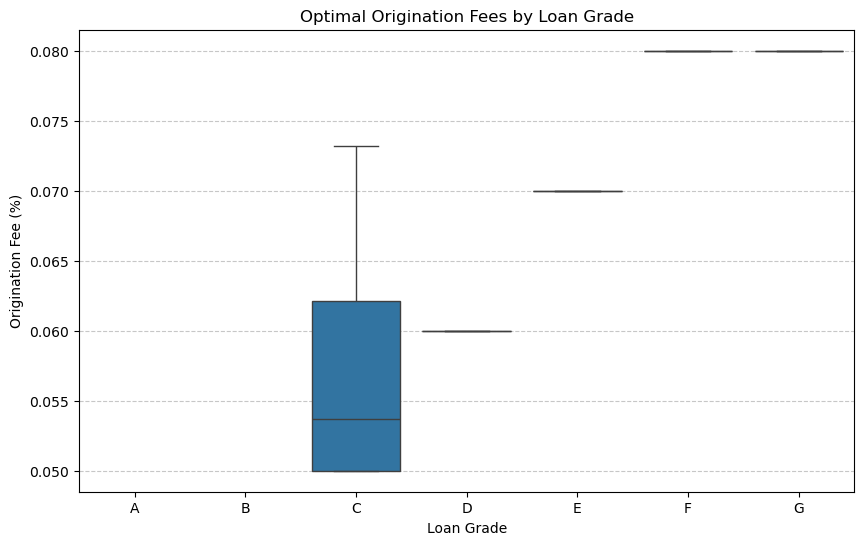

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=feasible_loans, x='grade', y='optimal_fee', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Optimal Origination Fees by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Origination Fee (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/ipykernel_28799/2224587206.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


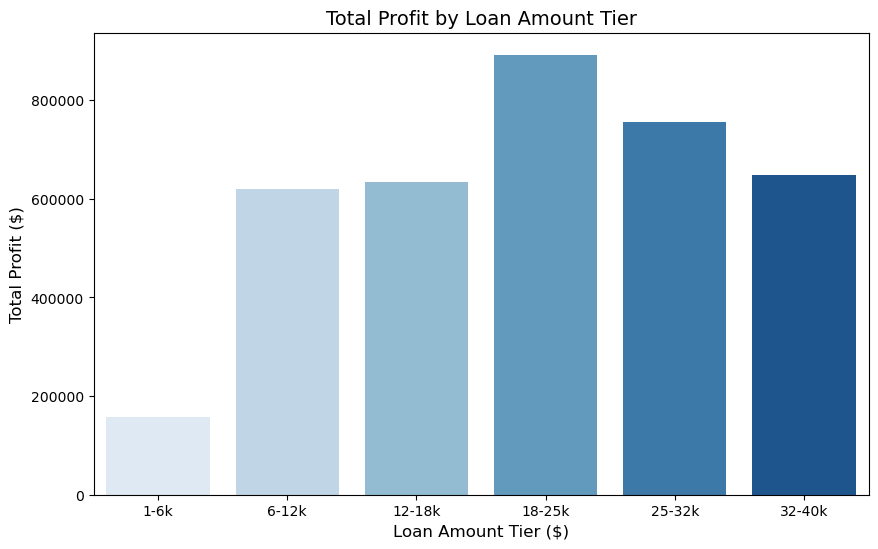

In [14]:
feasible_loans['amount_tier'] = pd.cut(
    feasible_loans['loan_amount'],
    bins=[0, 6000, 12000, 18000, 25000, 32000, 40000],
    labels=['1-6k', '6-12k', '12-18k', '18-25k', '25-32k', '32-40k']
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='amount_tier',
    y='profit',
    data=feasible_loans,
    estimator=sum,
    errorbar=None,
    palette='Blues'
)
plt.title("Total Profit by Loan Amount Tier", fontsize=14)
plt.xlabel("Loan Amount Tier ($)", fontsize=12)
plt.ylabel("Total Profit ($)", fontsize=12)
plt.savefig('profit_bytier.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/ipykernel_28799/3891585640.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profit_by_tier, x='grade', y='profit', palette='Blues_d')


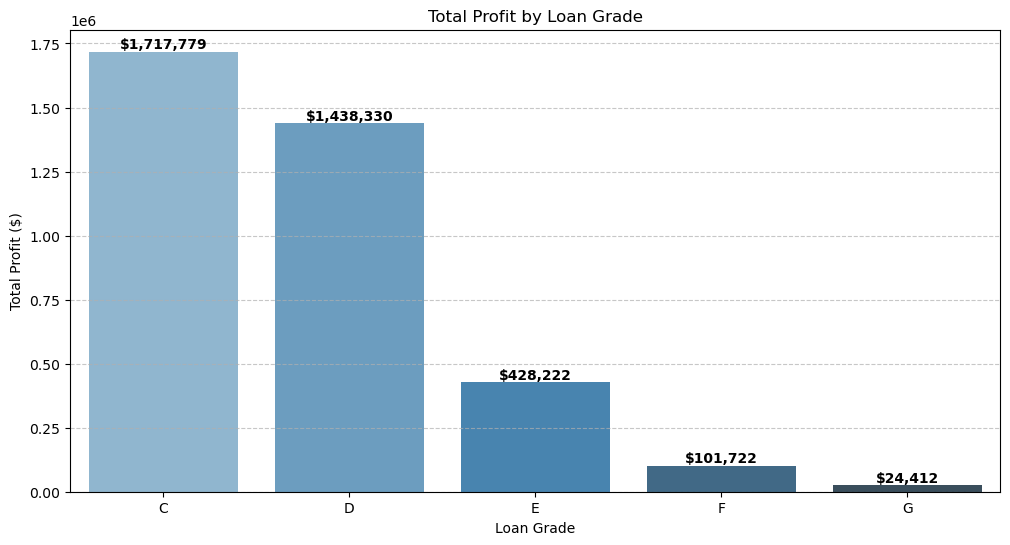

In [13]:
# Aggregate profit by grade
profit_by_tier = feasible_loans.groupby('grade')['profit'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=profit_by_tier, x='grade', y='profit', palette='Blues_d')
plt.title('Total Profit by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Total Profit ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for index, row in profit_by_tier.iterrows():
    plt.text(index, row['profit'], f"${row['profit']:,.0f}", 
             ha='center', va='bottom', fontweight='bold')

plt.show()

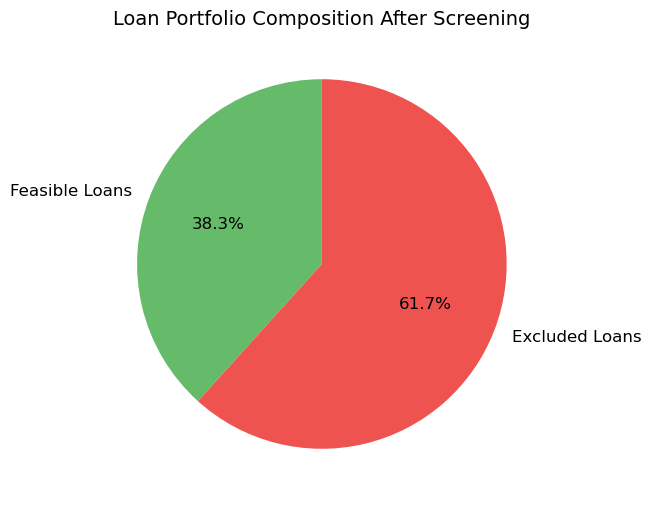

In [8]:
plt.figure(figsize=(8, 6))
plt.pie(
    [len(feasible_loans), len(loans) - len(feasible_loans)],
    labels=['Feasible Loans', 'Excluded Loans'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66BB6A', '#EF5350'],
    textprops={'fontsize': 12}
)
plt.title("Loan Portfolio Composition After Screening", fontsize=14)
plt.savefig('loancomposition.png', dpi=300, bbox_inches='tight')
plt.show()